In [1]:
%matplotlib inline
import numpy as np
from numpy import random
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
from operator import add
import itertools
from scipy import signal
import seaborn as sns
import nest



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: May 19 2024 15:53:53

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
import os
import sys
Path = os.getcwd()
sys.path.append(Path)
from utilities import *

In [3]:
def find_I(V_target_si, f, tau_si=10e-3, R_si=100e6, E_m_si=-60e-3):
    a_si = (-E_m_si+V_target_si) * math.sqrt(1 + (2*math.pi*f*tau_si)**2) / R_si
    a = a_si/(1e-12)
    print(f"I_amp for f={f}: {a:.1f}pA")

def isi_dist(ts):
    isi = []
    
    for i in range(len(ts)-1):
        isi.append(ts[i+1]-ts[i])
    plt.figure()
    plt.hist(isi, bins=10, histtype='step')
    plt.title("Histogram")
    plt.ylabel("Frequency")
    plt.xlabel("Interspike interval")

In [4]:
def plot_results(sim_time=5000, noisy=False, psd_segments=8, 
                 adjust_amp=False, adjust_thresh=False, second_sine=False, xLim=0,
                 a_values=[100], SD_values=[250], f_values=[12], beat=2,
                smaller_yLim=False, E_m=-60, V_th=-50, bin_size=1,
                 seed=np.random.randint(0,1e+6), resolution=0.25, legend=False,
                 fft_percentage=0.99, print_f=True, log=True, y_min=1e-7,
                harmonics=1, harmonics_beat=0, save_fig=False):
    """This function plots:
    - Membrane potential as a function of time for a given length within simulation time (xLim)
    - The PSD of the spike train
    - The PSD of the membrane potential

        a_values : providing custom amplitude values 
        adjust_thresh : or adjust the amplitude based on frequency.
        noisy: Y choose whether to include noise or not.
        """
    
    ###*************************SIMULATION**************************************
    tau_m = 10
    E_m_si = E_m*1e-3
    V_target_si = -55*1e-3 - E_m_si #dette gir <10mV, som er endringen vi ønsker 
    tau_si = 10*1e-3 #s
    R_si = 0.1*1e+9 #ohm
    mean_list = []

    
    if noisy:
        if adjust_amp or adjust_thresh:
            param_combos = list(itertools.product(f_values, SD_values))
        else:
            param_combos = [
            (f, a, sd) for f, a, sd in itertools.product(f_values, a_values, SD_values)
            if not (a == 0 and sd == 0)
        ]
    else:
        if adjust_amp or adjust_thresh:
             param_combos = list(itertools.product(f_values))
        else:
            param_combos = list(itertools.product(f_values, a_values))
    
    param_combos = np.atleast_1d(param_combos) #to allow for one single combination
    
        
    fig, axes = plt.subplots(nrows=len(param_combos), ncols=3, 
                             figsize=(15, 5*len(param_combos)))
    
    if len(param_combos) == 1:
        axes = np.array([axes])
    
    for idx, combo  in enumerate(param_combos):
        if noisy:
            if adjust_amp:
                f, sd = combo
                a_si = V_target_si * math.sqrt(1 + (2*math.pi*(f)*tau_si)**2) / R_si
                a = a_si/(1e-12)
            else:
                if adjust_thresh:
                    f, sd = combo
                    a_unadj_si = V_target_si / R_si
                    a = a_unadj_si/(1e-12)
                    
                    V_th_si = (a_unadj_si * R_si) / (math.sqrt(1 + (2*math.pi*f*tau_si)**2 ))
                    V_th = (V_th_si+E_m_si)/(1e-3)
                else:
                    f, a, sd = combo
                    
            if second_sine:
                results = build_simulation(sim_time=sim_time, noisy=True, second_sine=True,
                                        f1=f, beat=beat, a=a, SD=sd, tau_m=tau_m, V_thresh=V_th,
                                        seed=seed, resolution=resolution)                    
            else:
                results = build_simulation(sim_time=sim_time, noisy=True,
                f1=f, a=a, SD=sd,V_thresh=V_th, second_sine=second_sine, tau_m=tau_m,
                                        seed=seed, resolution=resolution)
            
        else:
            if adjust_amp:
                (f,) = combo
                a_si = V_target_si * math.sqrt(1 + (2*math.pi*f*tau_si)**2) / R_si
                a = a_si/(1e-12)
                
            elif adjust_thresh:
                (f,) = combo
                a_unadj_si = V_target_si / R_si
                a = a_unadj_si/(1e-12)
                    
                V_th_si = (a_unadj_si * R_si) / (math.sqrt(1 + (2*math.pi*f*tau_si)**2 ))
                V_th = (V_th_si+E_m_si)/(1e-3)
            else:
                f,a = combo
                
            if second_sine:
                results = build_simulation(sim_time=sim_time, noisy=False, second_sine=True,
                                        f1=f, beat=beat, a=a, SD=0, tau_m=tau_m, V_thresh=V_th,
                                        seed=seed, resolution=resolution)
            else:
                results = build_simulation(sim_time=sim_time, noisy=False,
                f1=f, a=a, V_thresh=V_th, E_m=E_m, tau_m=tau_m,
                                        seed=seed, resolution=resolution)
                
         #********************************RESULTS AND PLOTS********************************   
        spike_times = results["spike_times"]
        Vm = results["Vm"]
        V_th = results["V_th"]
        sim_time = results["sim_time"]
        times = results["times"]
        print(f"max_Vm = {np.max(Vm):.2f}")
    
        
        """--------test--------"""
        if noisy:
            std_Vm = np.std(Vm)
            std_Vm_corr = np.std(Vm - np.mean(Vm))
            if a == 0:
                print("-"*50)
                print(f"a: {a}, f={f}, sd={sd}")
                print(f"Standardavvik av Vm: {std_Vm:.4f} mV")
        
        
        #Background
        sns.set_style("whitegrid")
        plt.rcParams["font.family"] = "Liberation Serif"
        # Membrane potential with threshold 
        
        ax_vm = axes[idx,0]
        time_axis = np.linspace(0,sim_time,len(Vm))
        
        for t in spike_times:
            ax_vm.vlines(x=t, ymin=V_th, ymax=V_th+5, color="black") 
            
        ax_vm.plot(time_axis, Vm, color='#006D5B')
        
        ax_vm.axhline(V_th, linestyle='-', color='black', label="V_th")  # terskel-linje
        
        #-----------------TITLES---------------------
        letters = "ABCDEFGHIJKLMN"
        
        if noisy:
            if second_sine:
                title = rf"{letters[3*idx]}. $V_m$ ($f_1$ = {f:.0f}Hz, $f_2$ = {(f+beat):.0f}Hz, " + rf"$I_{{\mathrm{{amp}}}}$ = {a:.0f}pA)"
            else:
                title =  rf"{letters[3*idx]}. $V_m$ ($f$ = {f:.0f}Hz, $\sigma_I$ = {sd:.0f}pA, " + rf"$I_{{\mathrm{{amp}}}}$ = {a:.0f}pA)"
             
        else:
            if second_sine:
                title = rf"{letters[3*idx]}. $V_m$ ($f_1$ = {f:.0f}Hz, $f_2$ = {(f+beat):.0f}Hz, " + rf"$I_{{\mathrm{{amp}}}}$ = {a:.0f}pA)"
            else:
                title = rf"{letters[3*idx]}. $V_m$ ($f$ = {f:.0f}Hz, $I_{{\mathrm{{amp}}}}$ = {a:.0f}pA)"
                
                
        if a == 0:
            
            if second_sine == False:
                title = title.replace(r"($f$ = " + f"{f:.0f}" + r"Hz, ", "(")
    
            if second_sine: 
                title = title.replace(r"($f_1$ = " + f"{f:.0f}" + r"Hz, $f_2$ = " + f"{f + beat:.0f}" + r"Hz, ", "(")
        
        ax_vm.set_title(title,fontsize=18, fontweight='bold', color="#006D5B")
        
            


        ax_vm.set_xlim([0, sim_time])
        if xLim != 0:
            ax_vm.set_xlim(1000, 1000+1000*xLim) 
        dV = np.max(Vm-E_m)
        #ax_vm.set_ylim([np.min(Vm)-0.03*dV,np.max(Vm)+0.5*dV])
        ax_vm.set_ylim([-70,-48])
        #ax_vm.set_ylim(-65,-55)
        ax_vm.set_xlabel("Time [ms]", color="#006D5B", fontsize=16)
        ax_vm.set_ylabel("$V_m$ [mV]", color="#006D5B",fontsize=16)
        
        #chat-gpt:
        ax_vm.set_facecolor("#F5F5F5")
        ax_vm.spines["top"].set_visible(False)
        ax_vm.spines["right"].set_visible(False)
        ax_vm.spines["left"].set_color("#333333")
        ax_vm.spines["bottom"].set_color("#333333")
        ax_vm.xaxis.label.set_color("#006D5B")
        ax_vm.yaxis.label.set_color("#006D5B")
        ax_vm.tick_params(axis='both', colors="#333333", labelsize='large')
        ax_vm.grid(color='#A3D4CC', linestyle='-', linewidth=0.5)
        ax_vm.legend(facecolor="white", framealpha=1, edgecolor="#333333", fontsize=16)
        
    
        
        # PSD of spike train
        
        freqs, psd_values = psd(spike_times, sim_time, bin_size, segments=psd_segments)
        arg_f = np.argmin(np.abs(freqs - f))
        if second_sine:
            arg_f = np.argmin(np.abs(freqs - f))
        print("10 last freqs:", freqs[:-10])
        ax_fft = axes[idx,1]
        
        
        # Vertical lines, colors filled in by chat GPT
        
        beat_colors = ["#1E3A8A", "#2563EB", "#60A5FA", "#38BDF8"] #Blue colors for beat frequencies
        colors = ["#009879", "#4CAF50", "#8BC34A", "#CDDC39", "#FFEB3B"]  # Green colors for harmonics
        
        for i in range(1,harmonics_beat+1):
            ax_fft.axvline(i*beat, linestyle="--", dashes=(2, 5), color=beat_colors[i], label=f"f={i*beat}Hz")
            
        for i in range(1,harmonics+1):
            ax_fft.axvline(i*f, linestyle="--", dashes=(2, 5), color=colors[i], label=f"f={i*f}Hz")
            if second_sine:
                ax_fft.axvline(i*(f+beat), linestyle="--", dashes=(2, 5), color=colors[i+harmonics], label=f"f={i*(f+beat)}Hz")
            ax_fft.legend()
        
        keep_args = psd_values > 1e-30
        psd_values = psd_values[keep_args]
        freqs = freqs[keep_args]
        
        ax_fft.plot(freqs, psd_values, color="#006D5B") 
        if len(freqs) > 0:
            xMax = max(f,np.max(freqs))*1.1
            
            
        #-----------Create empty log-plot----------   
        if len(psd_values) == 0:
        
            ax_fft.loglog([1], [1e-16], alpha=0)  # Usynlig punkt for å sette aksene
            ax_fft.set_xlim(1, 2e3)
            ax_fft.set_ylim(1e-16, 1e-10)
            ax_fft.set_title("PSD of spike train (No spikes)", fontsize=14, fontweight="bold", color="#006D5B")
            ax_fft.set_xscale("log")
            ax_fft.set_yscale("log")
            
        if len(psd_values) > 0:
            ymin = max(3e-5, np.min(np.abs(psd_values)))
            ax_fft.set_ylim(ymin,np.max(np.abs(psd_values))*1.1)
            ax_fft.set_xscale("log")
            ax_fft.set_yscale("log")
        
        ax_fft.set_xlim(1,2e3)
        ax_fft.set_xlabel("Frequency (Hz)", color="#006D5B", fontsize=16)
        ax_fft.set_ylabel(r'PSD [$\mathrm{spikes}^2/\mathrm{Hz}$]', color="#006D5B", fontsize=16)
        ax_fft.set_title(f"{letters[1+3*idx]}. PSD of spike train", fontsize=20, fontweight='bold', color="#006D5B")
        
        # Generated by ChatGPT (adapted afterwards):
        ax_fft.set_facecolor("#F5F5F5")
        ax_fft.spines["top"].set_visible(False)
        ax_fft.spines["right"].set_visible(False)
        ax_fft.spines["left"].set_color("#333333")
        ax_fft.spines["bottom"].set_color("#333333")
        ax_fft.xaxis.label.set_color("#006D5B")
        ax_fft.yaxis.label.set_color("#006D5B")
        ax_fft.tick_params(axis='both', colors="#333333", labelsize='large')
        
        # enabling placement of legend outside plots if necessary
        if legend:
            ax_fft.legend(edgecolor="#333333", fontsize=16, loc="upper center", bbox_to_anchor=(0.5, -0.25), ncol=3)
        else:
            ax_fft.legend(facecolor="white", framealpha=1, edgecolor="#333333", fontsize=16)
        
        # Calculating simulated SNR
        if len(psd_values) > 0:
            if noisy:
                if second_sine:
                    df, noise_avg = simulated_SNR(Vm, a, psd_values, f_values, f, freqs, bin_size, tau_m, 
                      arg_f, sim_time, sd, beat, spike_times, seed, second_sine)
                else:
                    df, noise_avg = simulated_SNR(Vm, a, psd_values, f, freqs, 
                      arg_f, sim_time, sd, beat, spike_times, seed, second_sine)
                    
                display(df)
          
    
        # PSD of membrane potential
        freqs, psd_vm = psd_Vm(Vm, times, resolution)
        psd_vm = np.abs(psd_vm)
        keep_args = psd_vm > 1e-30
        psd_vm = psd_vm[keep_args]
        freqs = freqs[keep_args]
    
        ax_fft_vm = axes[idx,2]
        for i in range(1,harmonics_beat+1):
            ax_fft_vm.axvline(i*beat, linestyle="--", dashes=(2, 5), color=beat_colors[i], label=f"f={i*beat}Hz")
            
        for i in range(1,harmonics+1):
            ax_fft_vm.axvline(i*f, linestyle="--", dashes=(2, 5), color=colors[i], label=f"f={i*f:.0f}Hz")
            if second_sine:
                ax_fft_vm.axvline(i*(f+beat), linestyle="--", dashes=(2, 5), color=colors[i+harmonics], label=f"f={i*(f+beat):.0f}Hz")
            
    
        
        ax_fft_vm.plot(freqs, np.abs(psd_vm), color='#006D5B')  
        ax_fft_vm.set_xlim(1, 2e3)           
        if len(psd_vm) > 0:
            ymin = max(y_min, np.min(np.abs(psd_vm)))
            ax_fft_vm.set_ylim(ymin,10*np.max(np.abs(psd_vm)))
      
        ax_fft_vm.set_xlabel("Frequency [Hz]", color="#006D5B", fontsize=16)
        ax_fft_vm.set_ylabel(r'PSD [$\mathrm{mV}^2/\mathrm{Hz}$]', color="#006D5B", fontsize=16)
        ax_fft_vm.set_title(f"{letters[2+3*idx]}. PSD of $V_m$", fontsize=20, fontweight='bold', color="#006D5B")
        
        if log and len(psd_vm)>0:
            ax_fft_vm.set_xscale("log")
            ax_fft_vm.set_yscale("log")
        
        #generated by chatGPT
        ax_fft_vm.set_facecolor("#F5F5F5")
        ax_fft_vm.spines["top"].set_visible(False)
        ax_fft_vm.spines["right"].set_visible(False)
        ax_fft_vm.spines["left"].set_color("#333333")
        ax_fft_vm.spines["bottom"].set_color("#333333")
        ax_fft_vm.xaxis.label.set_color("#006D5B")
        ax_fft_vm.yaxis.label.set_color("#006D5B")
        ax_fft_vm.tick_params(axis='both', colors="#333333", labelsize='large')
        ax_fft_vm.grid(color='#B0B0B0', linestyle='-', linewidth=0.5)
    
        if legend:
            continue
        else:
            ax_fft_vm.legend(facecolor="white", framealpha=1, edgecolor="#333333", fontsize=16)
        
    
    plt.tight_layout()
    if save_fig:
        save_dir = os.path.join(os.getcwd(), "results")
        os.makedirs(save_dir, exist_ok=True)
        file_index = 1
        while os.path.exists(os.path.join(save_dir, f"main_{file_index}.png")):
            file_index += 1
        
        save_path = os.path.join(save_dir, f"main_{file_index}.png")
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        
        print(f"Saved plot as: {save_path}")
        
    plt.show()
    
    
    
    

In [5]:
import math 

def calculate_SD(tau_si, C_m_si, Vm_SD, delta):
    SD_si = math.sqrt( (2 * C_m_si**2 * Vm_SD**2) / (delta * tau_si ))
    SD = SD_si / (1e-12)
    return SD

SD = calculate_SD(tau_si=10*1e-3, C_m_si=100*1e-12, Vm_SD=4.0*1e-3, delta=5e-4)
print(f"Resolution = 1.0 ms. SD I_noise: {SD:.2f} pA")


Resolution = 1.0 ms. SD I_noise: 252.98 pA


In [6]:
find_I(-51e-3, 10)

I_amp for f=10: 106.3pA


max_Vm = -45.19
10 last freqs: [0.0000e+00 8.0000e-01 1.6000e+00 ... 1.7904e+03 1.7912e+03 1.7920e+03]
Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/main_43.png


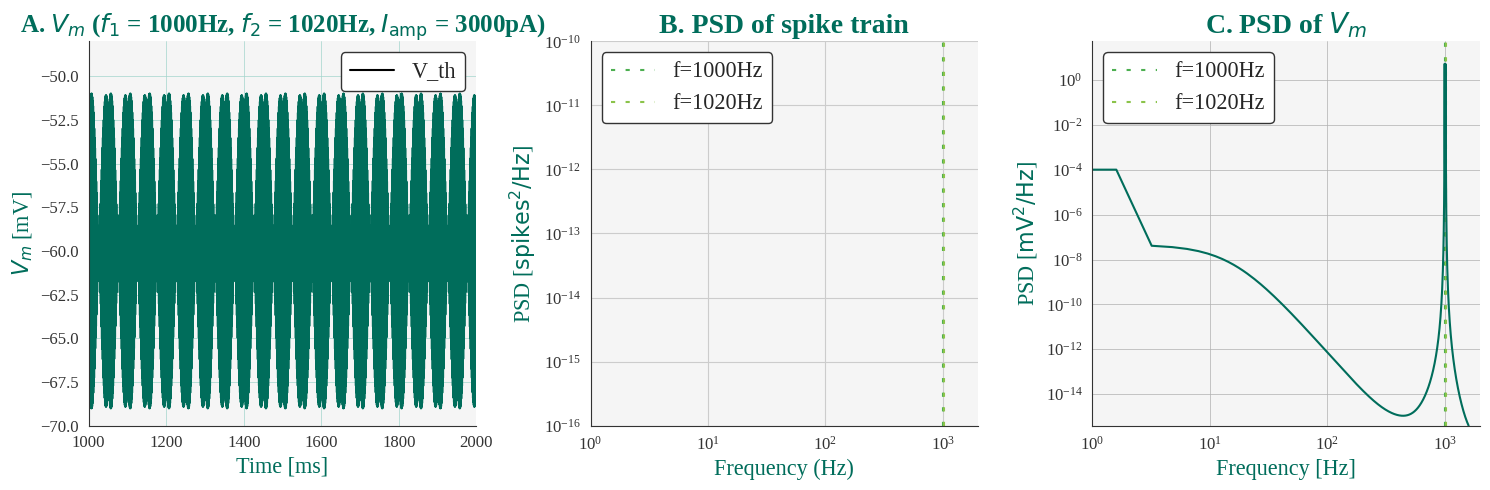

In [13]:
plot_results(sim_time=10e3,
             a_values=[3000],f_values=[1000], SD_values=[0],
             noisy=True, xLim=1, seed=2, print_f=False,V_th=0,
             bin_size=0.25, second_sine=True, harmonics=1,beat=20,
            save_fig=True, resolution=0.25, y_min=1e-16)

max_Vm = -51.38
10 last freqs: [0.00000e+00 8.00000e-02 1.60000e-01 ... 1.97904e+03 1.97912e+03
 1.97920e+03]
Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/main_36.png


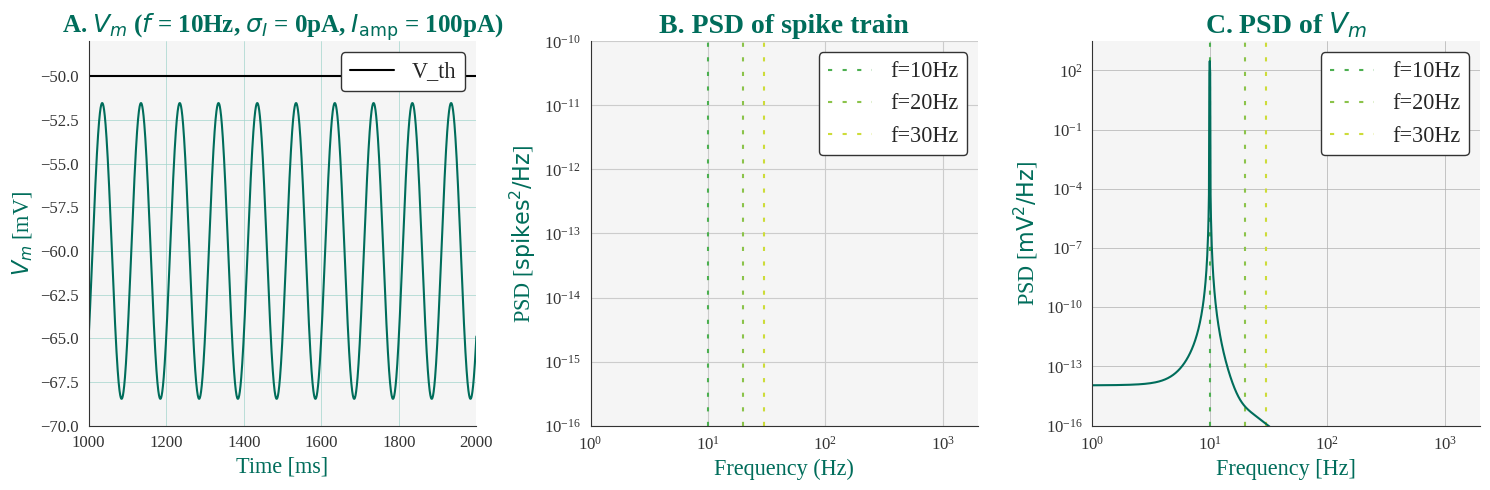

In [10]:
plot_results(sim_time=100e3,
             a_values=[100],f_values=[10], SD_values=[0],
             noisy=True, xLim=1, seed=2, print_f=False,
             bin_size=0.25, second_sine=False, harmonics=3,
            save_fig=True, resolution=0.25, y_min=1e-16)

max_Vm = -50.01
10 last freqs: [0.00000e+00 8.00000e-02 1.60000e-01 ... 1.97904e+03 1.97912e+03
 1.97920e+03]
max_Vm = -50.05
10 last freqs: [0.00000e+00 8.00000e-02 1.60000e-01 ... 1.97904e+03 1.97912e+03
 1.97920e+03]
Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/main_11.png


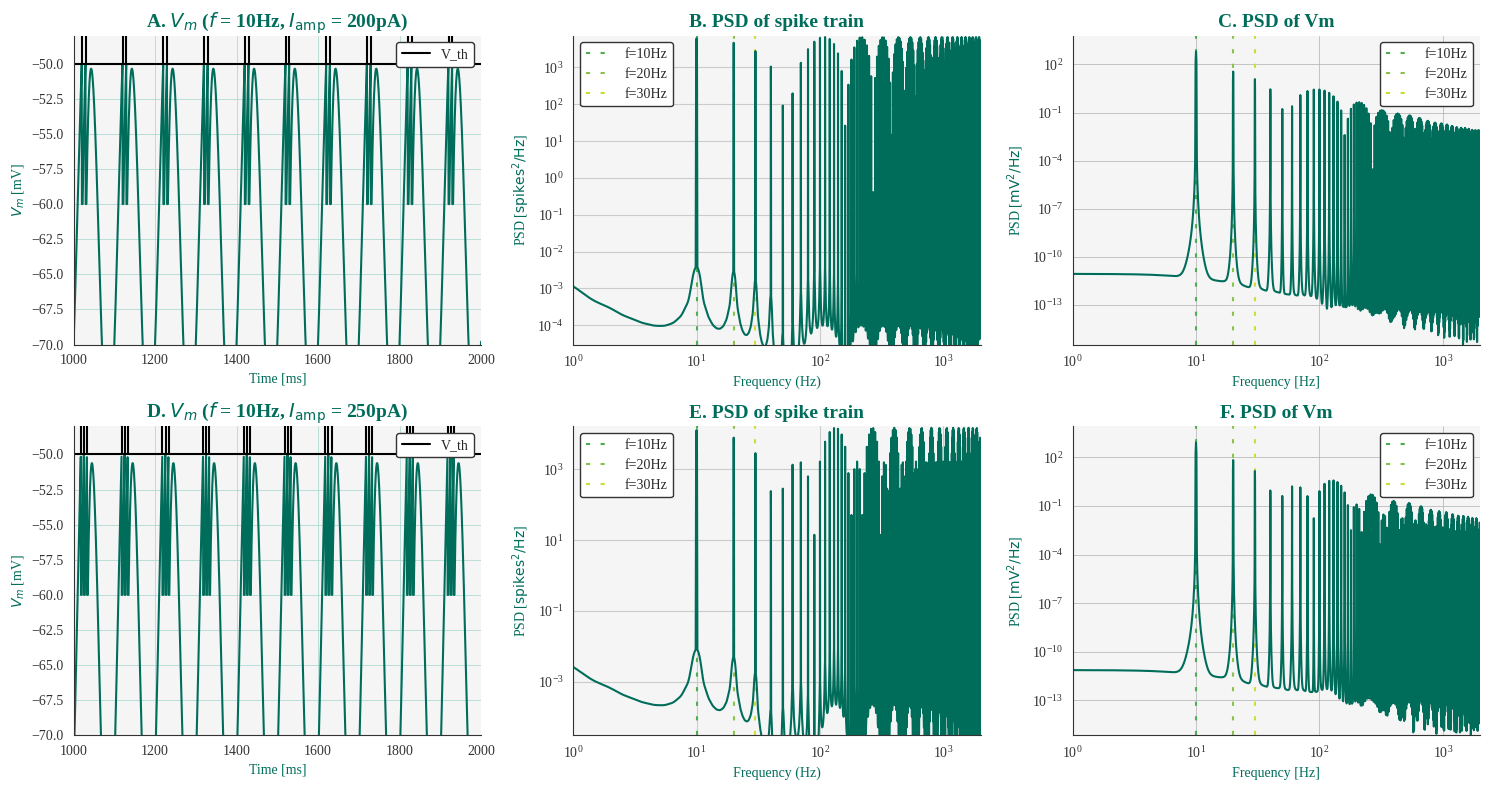

In [27]:
plot_results(sim_time=100e3,
             a_values=[200,250],SD_values=[250], f_values=[10], 
             noisy=False, xLim=1, seed=2, print_f=False,
             bin_size=0.25, second_sine=False, harmonics=3,
            save_fig=True, resolution=0.25, y_min=1e-16)

In [28]:
find_I(-51e-3, 1000)

I_amp for f=1000: 5655.6pA


max_Vm = -57.46
10 last freqs: [0.00000e+00 1.60000e-01 3.20000e-01 ... 1.95808e+03 1.95824e+03
 1.95840e+03]
max_Vm = -50.00
10 last freqs: [0.00000e+00 1.60000e-01 3.20000e-01 ... 1.95808e+03 1.95824e+03
 1.95840e+03]
len psd values 12251, arg_f 625
noise_avg for f 4.8310851648461774


,Input Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],FFT Amplitude for f [(spikes pr sec)/Hz],Frequency at max (Hz),Mean FFT Amplitude (mV),Approx. SNR,Spike Rate (spikes/s)
0,100,100,-50.003088,38.09,38.09,100.0,4.8311,7.89,3.16


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/main_4.png


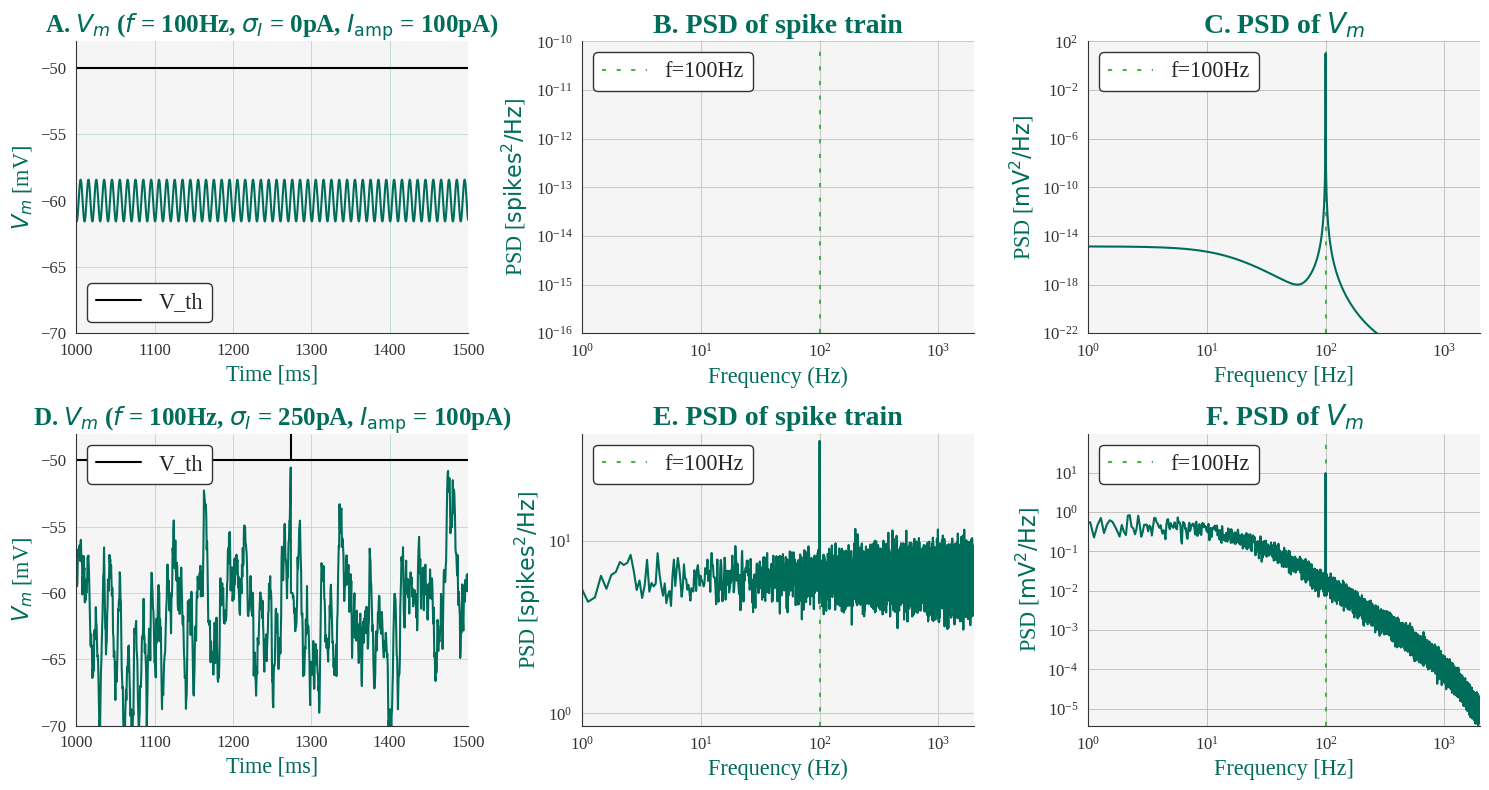

In [7]:
plot_results(sim_time=100000,save_fig=True,
             a_values=[100],f_values=[100], SD_values=[0,250],
             noisy=True, seed=42, bin_size=0.25, second_sine=False, 
             resolution=0.25, xLim=0.5, y_min=1e-22)

max_Vm = -59.26
10 last freqs: [0.00000e+00 1.60000e-01 3.20000e-01 ... 1.95808e+03 1.95824e+03
 1.95840e+03]
max_Vm = -52.79
10 last freqs: [0.00000e+00 1.60000e-01 3.20000e-01 ... 1.95808e+03 1.95824e+03
 1.95840e+03]
Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/main_5.png


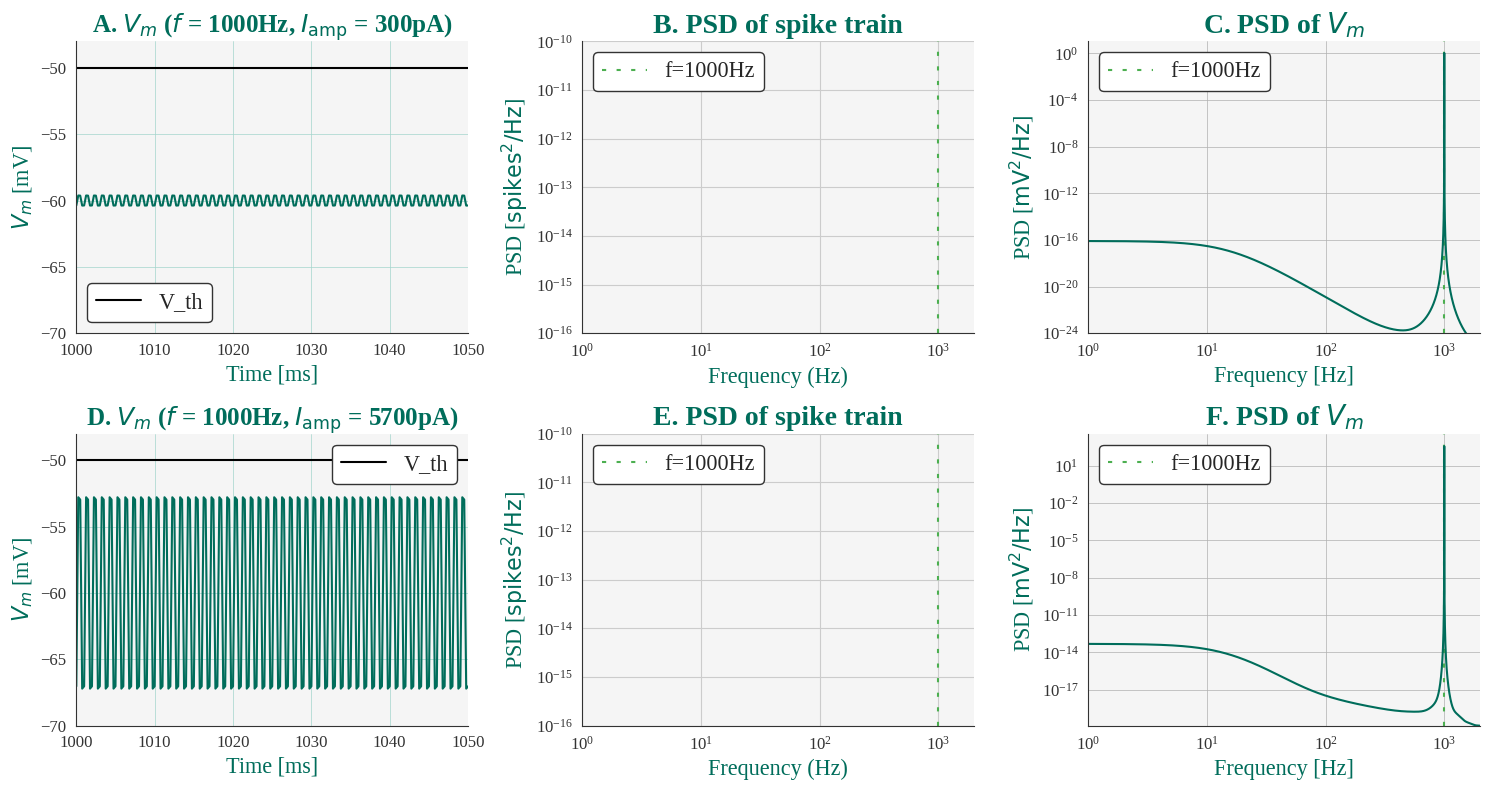

In [8]:
plot_results(sim_time=100e3, SD_values=[0],
             a_values=[300,5700],f_values=[1000],
             noisy=False, xLim=0.05, seed=42, bin_size=0.25, second_sine=False, fft_percentage=0.9,
            harmonics=1, save_fig=True, log=True, resolution=0.25, y_min=1e-24)

max_Vm = -50.00
10 last freqs: [0.00000e+00 1.60000e-01 3.20000e-01 ... 1.95808e+03 1.95824e+03
 1.95840e+03]
len psd values 12251, arg_f 6250
noise_avg for f 5.372951017025921


,Input Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],FFT Amplitude for f [(spikes pr sec)/Hz],Frequency at max (Hz),Mean FFT Amplitude (mV),Approx. SNR,Spike Rate (spikes/s)
0,1000,100,-50.000156,9.2,6.71,58.4,5.373,1.25,2.49


max_Vm = -50.00
10 last freqs: [0.00000e+00 1.60000e-01 3.20000e-01 ... 1.95808e+03 1.95824e+03
 1.95840e+03]
len psd values 12251, arg_f 6250
noise_avg for f 5.372951017025921


,Input Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],FFT Amplitude for f [(spikes pr sec)/Hz],Frequency at max (Hz),Mean FFT Amplitude (mV),Approx. SNR,Spike Rate (spikes/s)
0,1000,300,-50.000061,14.67,14.67,1000.0,5.373,2.73,2.6


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/main_6.png


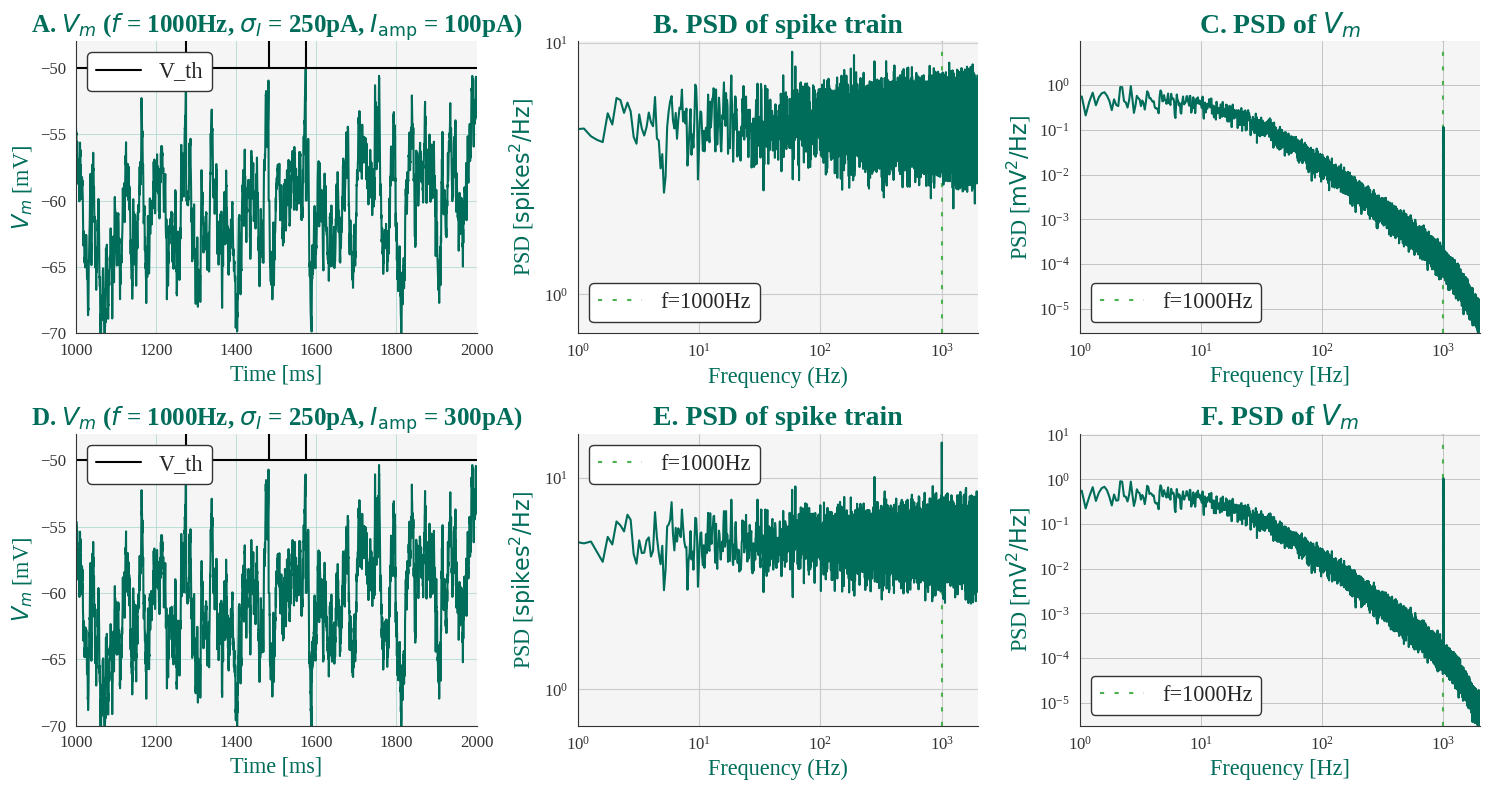

In [9]:
plot_results(sim_time=100e3, SD_values=[250],
             a_values=[100,300],f_values=[1000],
             noisy=True, xLim=1, seed=42, bin_size=0.25, second_sine=False, fft_percentage=0.9,
            harmonics=1, save_fig=True, resolution=0.25, y_min=1e-16)

max_Vm = -51.89
10 last freqs: [0.00000e+00 8.00000e-02 1.60000e-01 ... 1.97904e+03 1.97912e+03
 1.97920e+03]
max_Vm = -56.51
10 last freqs: [0.00000e+00 8.00000e-02 1.60000e-01 ... 1.97904e+03 1.97912e+03
 1.97920e+03]
max_Vm = -59.63
10 last freqs: [0.00000e+00 8.00000e-02 1.60000e-01 ... 1.97904e+03 1.97912e+03
 1.97920e+03]
Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/main_21.png


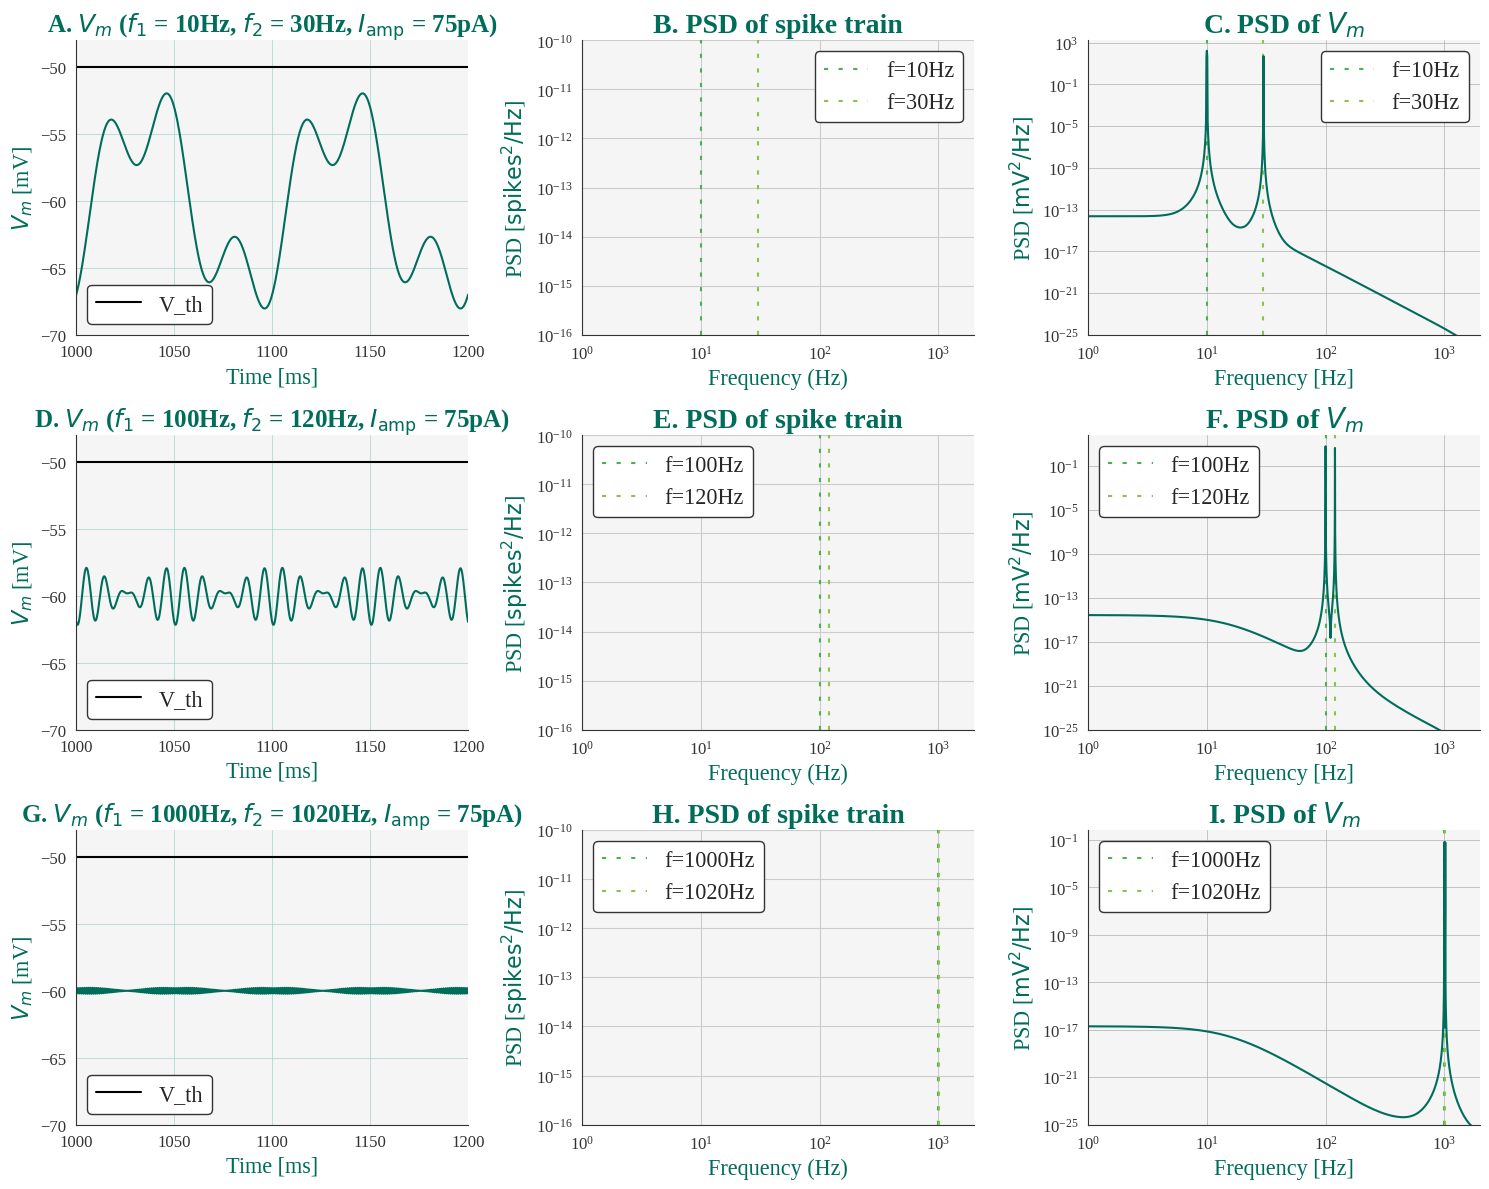

In [24]:
"""Dobbel sinus uten noise """
plot_results(sim_time=100e3,a_values=[75], f_values=[10,100,1000], noisy=False,
             second_sine=True, beat=20, xLim=0.2, seed=42, harmonics=1, psd_segments=8,
             bin_size=0.25, resolution=0.25, print_f=False, save_fig=True, y_min=1e-25)

max_Vm = -59.51
10 last freqs: [0.00000e+00 8.00000e-02 1.60000e-01 ... 1.97904e+03 1.97912e+03
 1.97920e+03]
Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/main_8.png


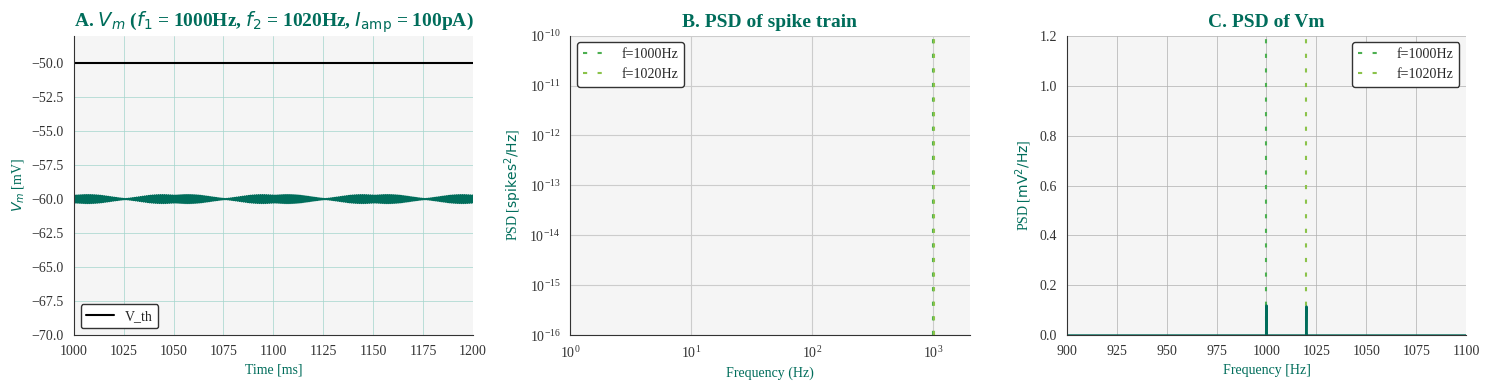

In [17]:
"""changed xLim in PSD of Vm to make sure there are two and not only one peak"""
plot_results(sim_time=100e3,a_values=[100], f_values=[1000], noisy=False, log=False,
             second_sine=True, beat=20, xLim=0.2, seed=42, harmonics=1, psd_segments=8,
             bin_size=0.25, resolution=0.25, print_f=False, save_fig=True, y_min=1e-16)

max_Vm = -50.00
10 last freqs: [0.00000e+00 8.00000e-02 1.60000e-01 ... 1.97904e+03 1.97912e+03
 1.97920e+03]
len psd values 24751, arg_f 125
noise_avg for f 21.619864134703963


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat)
0,"[10, 30]",20,100,-50.000036,1996.33,1996.33,138.7,10.0,92.34,21.62,16.25,8.8,15.8


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/main_47.png


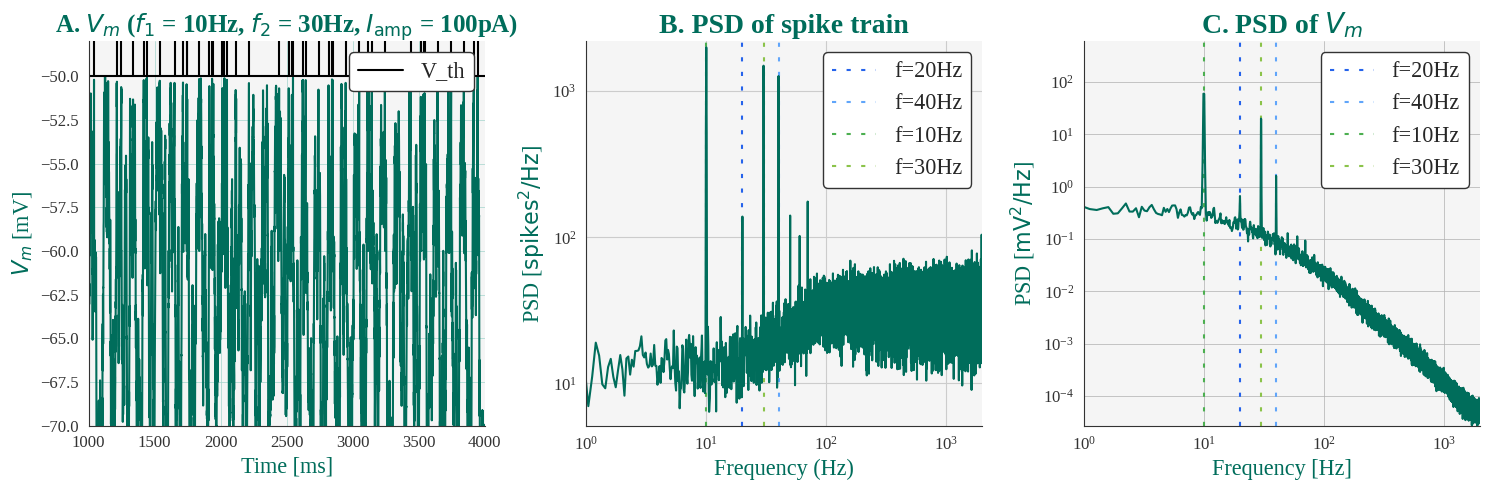

In [6]:
plot_results(sim_time=100e3, SD_values=[250],
             a_values=[100], f_values=[10], second_sine=True, beat=20, psd_segments=8,
             noisy=True, xLim=3, seed=42, bin_size=0.25, resolution=0.25, print_f=False, harmonics_beat=2, save_fig=True)


May 15 00:26:16 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.1 to 0.25 ms

May 15 00:26:16 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.25 ms.
max_Vm = -50.00
10 last freqs: [0.00000e+00 8.00000e-02 1.60000e-01 ... 1.97904e+03 1.97912e+03
 1.97920e+03]
len psd values 24751, arg_f 1250
noise_avg for f 7.919087534828216


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat)
0,"[100, 120]",20,100,-50.001332,90.14,90.14,19.82,100.0,11.38,7.92,3.92,2.7,7.4


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/main_46.png


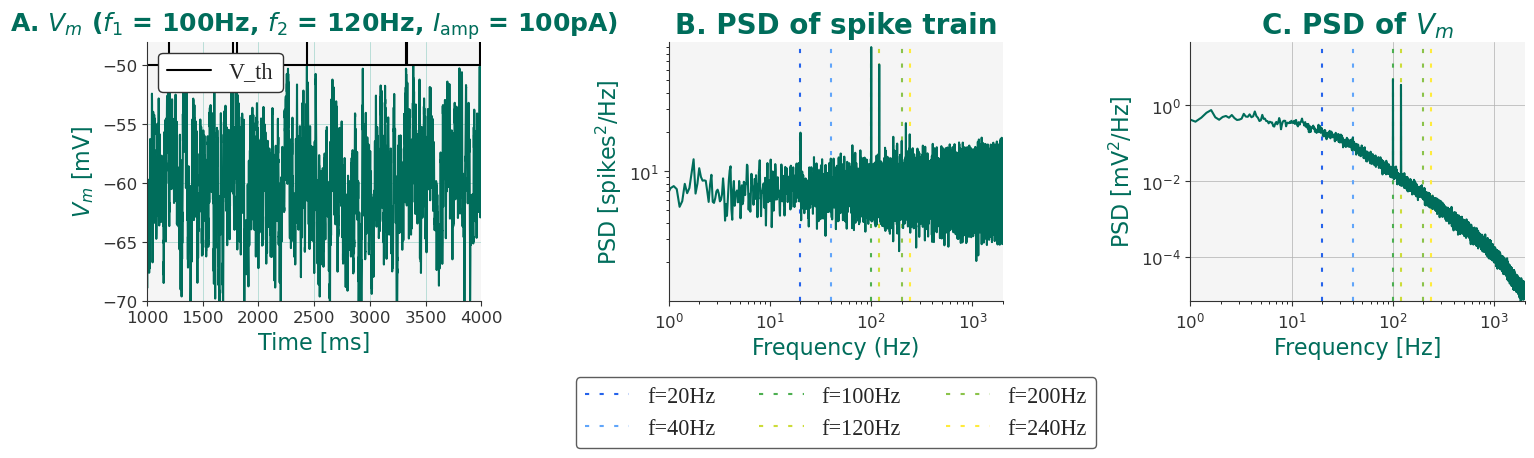

In [5]:
plot_results(sim_time=100e3, SD_values=[250], legend=True,
             a_values=[100], f_values=[100], second_sine=True, beat=20, psd_segments=8, harmonics=2,
             noisy=True, xLim=3, seed=100, bin_size=0.25, resolution=0.25, print_f=False, harmonics_beat=2, save_fig=True)


May 09 12:04:49 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.1 to 0.25 ms

May 09 12:04:49 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.25 ms.
max_Vm = -50.00
10 last freqs: [0.00000e+00 1.60000e-01 3.20000e-01 ... 1.95808e+03 1.95824e+03
 1.95840e+03]
len psd values 12251, arg_f 6250
noise_avg for f 7.1260685714803795


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),Mean PSD Amplitude (mV),SNR (f),Spike Rate (spikes/s),SNR (beat)
0,"[1000, 1020]",20,500,-50.000758,49.05,36.66,12.86,1020.0,7.1261,5.14,3.65,1.81


max_Vm = -50.00
10 last freqs: [0.00000e+00 1.60000e-01 3.20000e-01 ... 1.95808e+03 1.95824e+03
 1.95840e+03]
len psd values 12251, arg_f 6250
noise_avg for f 11.901106342750335


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),Mean PSD Amplitude (mV),SNR (f),Spike Rate (spikes/s),SNR (beat)
0,"[1000, 1020]",20,1000,-50.000394,164.94,134.82,41.29,1020.0,11.9011,11.33,5.94,3.71


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/main_35.png


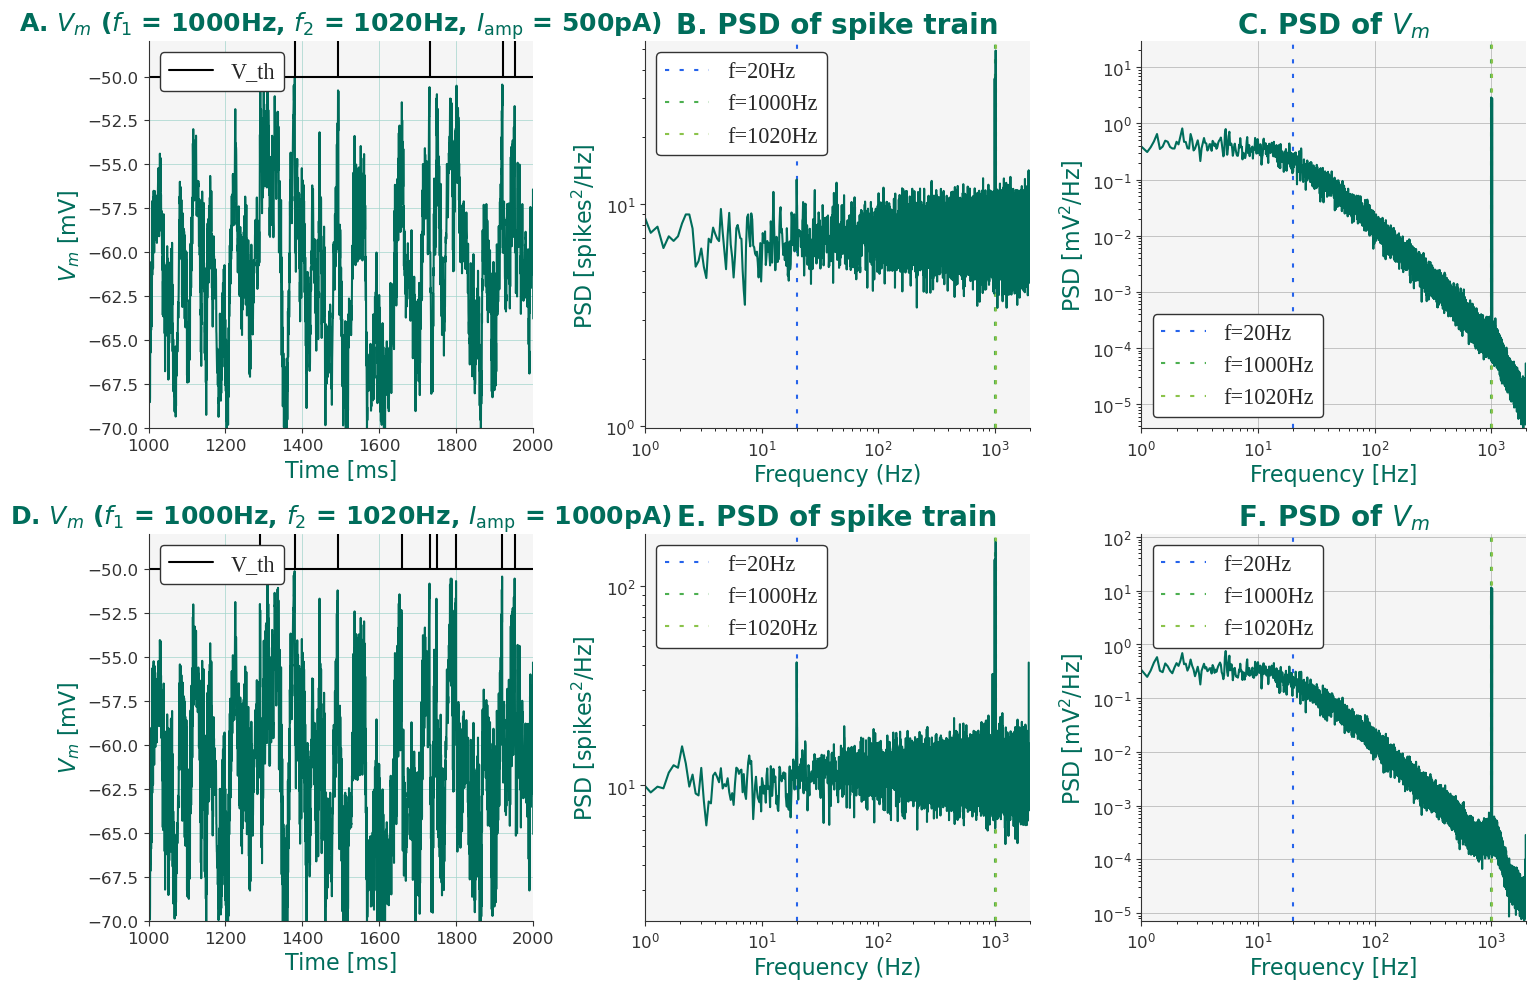

In [5]:
plot_results(sim_time=100e3, SD_values=[250],
             a_values=[500,1000], f_values=[1000], second_sine=True, beat=20, y_min=5e-10, harmonics=1,
             noisy=True, xLim=True, seed=281532, bin_size=0.25, resolution=0.25, print_f=False, harmonics_beat=1, save_fig=True)

max_Vm = -51.4
#spikes: 0


/tmp/ipykernel_576/309975315.py:195: UserWarning:Data has no positive values, and therefore cannot be log-scaled.


,Input Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],FFT Amplitude for f [(spikes pr sec)/Hz],Frequency at max (Hz),Mean FFT Amplitude (mV),Approx. SNR,Spike Rate (spikes/s)
0,10,100,-51.376535,0.0,0.0,2.0,0.0,NaN,0.0


max_Vm = -50.0
#spikes: 647


,Input Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],FFT Amplitude for f [(spikes pr sec)/Hz],Frequency at max (Hz),Mean FFT Amplitude (mV),Approx. SNR,Spike Rate (spikes/s)
0,10,100,-50.000558,0.26,0.24,1000.0,0.0,NaN,6.47


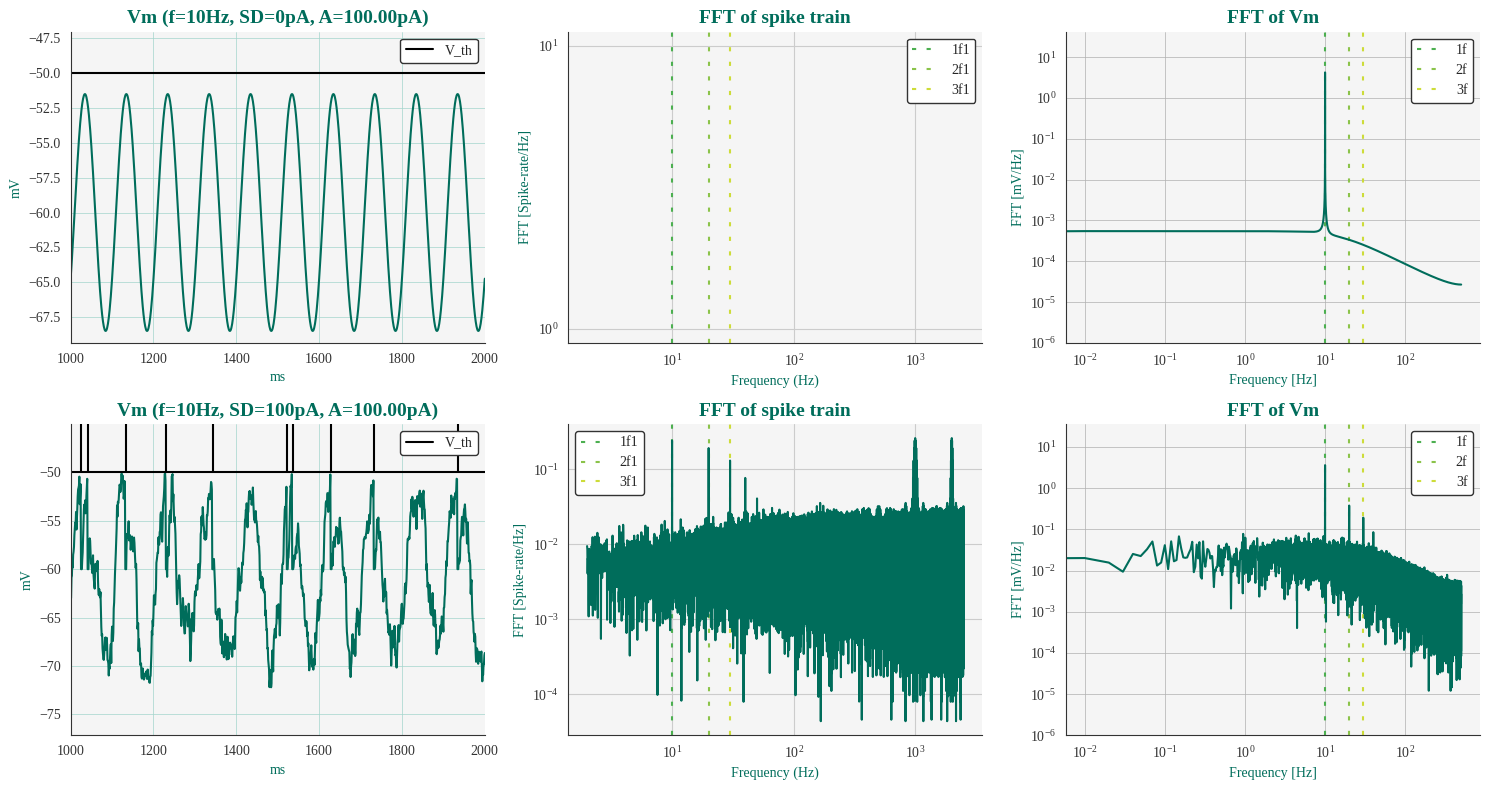

In [11]:
"""stochastic resonance"""
plot_results(sim_time=100000, SD_values=[0,100],
             a_values=[100],f_values=[10], print_f=False,
             noisy=True, xLim=1, seed=5, bin_size=0.2, second_sine=False, fft_percentage=0.999,
            harmonics=3, save_fig=False)
